In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [108]:
def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    # Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    Pdf_safe = Pdf
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [161]:
location = 'Cape_Hatteras'
week = 16
member = 1
member_list = np.arange(1, 51)

# t = 730-12*7

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
P_m = xr.open_dataset(file_path)
P_m = P_m.sortby('hexint')

hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

prior = 1/len(member_list) # 1/50 same for all members
posterior = np.zeros((len(member_list), len(P_m.hexint)))

for i, member in enumerate(member_list):
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_temporal/P_W{week:01d}_m{member:03d}.nc"
    P_m = xr.open_dataset(file_path)
    P_m = P_m.sortby('hexint')
    likelihood = P_m['probability'][:, :].values
    hypothesis = likelihood * prior
    posterior[i, :] = np.nanmean(hypothesis, axis=1)

normalizing = np.nansum(posterior, axis=0)

for j in range(len(P_m.hexint)):
    posterior[:, j] = posterior[:, j] / normalizing[j]
    
H = np.zeros_like(posterior[0, :])

for j in range(len(P_m.hexint)):
    H[j] = Shannon_entropy(posterior[:, j])
    
H = np.where(H > 0, H, np.nan)

/tmp/ipykernel_838171/1167938224.py:29: RuntimeWarning: invalid value encountered in divide
  posterior[:, j] = posterior[:, j] / normalizing[j]
/tmp/ipykernel_838171/81643026.py:6: RuntimeWarning: divide by zero encountered in log2
  return -np.nansum(Pdf_safe * np.log2(Pdf_safe))
/tmp/ipykernel_838171/81643026.py:6: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(Pdf_safe * np.log2(Pdf_safe))


In [162]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

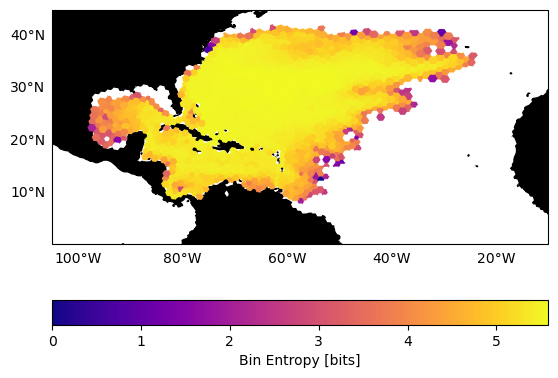

In [164]:
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-105, -10, 0, 45], crs=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5, alpha=0.)
gl.top_labels = False
gl.right_labels = False

im = hexbin_grid.pcolorhex(H, ax=ax, cmap='plasma', draw_edges=False, maxnorm=np.nanmax(H))
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label=f'Bin Entropy [bits]')

In [166]:
max_prob = np.ones(50)/50
max_ent = Shannon_entropy(max_prob)

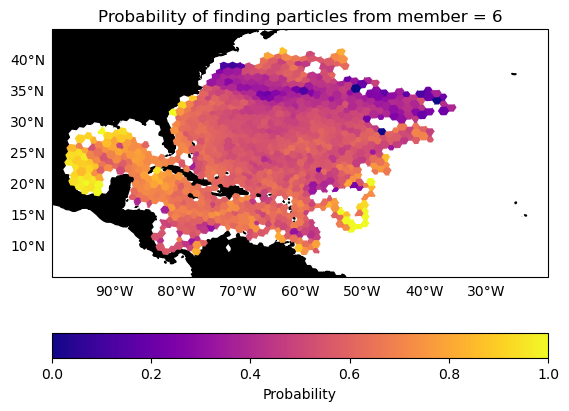

In [174]:

fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-100, -20, 5, 45], crs=cartopy.crs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5, alpha=0.)
gl.top_labels = False
gl.right_labels = False

m = 6
im = hexbin_grid.pcolorhex(posterior[m, :], ax=ax, cmap='plasma', draw_edges=False, maxnorm=1)
ax.set_title(f'Probability of finding particles from member = {m}')

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label=f'Probability')
